In [10]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import random
from scipy import ndimage
from patchify import patchify 
from PIL import ImageOps, Image

dir = "./training_data"

In [11]:
paths = [path for path in os.listdir(dir) if "Image" in path]

images = [cv2.imread(os.path.join(dir, path), cv2.IMREAD_GRAYSCALE) for path in paths]
masks = [cv2.imread(os.path.join(dir, path.replace("Image", "Segmentation")), cv2.IMREAD_GRAYSCALE) for path in paths]

threshold = 180
masks = [(mask > threshold).astype(np.uint8) * 255 for mask in masks]

def make_square(image):
    image_pil = Image.fromarray(image)
    return ImageOps.pad(image_pil, (max(image_pil.size), max(image_pil.size)), color=0)
    

images_square = [np.array(make_square(image)) for image in images]
masks_square = [np.array(make_square(mask)) for mask in masks]

images_resized = np.array([cv2.resize(image, (512, 512)) for image in images_square])
masks_resized = np.array([cv2.resize(mask, (512, 512)) for mask in masks_square])

patch_size = 256
step = 256
     

all_img_patches = []
for img in range(images_resized.shape[0]):
    large_image = images_resized[img]
    patches_img = patchify(large_image, (patch_size, patch_size), step=step)  #Step=256 for 256 patches means no overlap

    for i in range(patches_img.shape[0]):
        for j in range(patches_img.shape[1]):

            single_patch_img = patches_img[i,j,:,:]
            all_img_patches.append(single_patch_img)

images_resized = np.array(all_img_patches)

#Let us do the same for masks
all_mask_patches = []
for img in range(masks_resized.shape[0]):
    large_mask = masks_resized[img]
    patches_mask = patchify(large_mask, (patch_size, patch_size), step=step)  #Step=256 for 256 patches means no overlap

    for i in range(patches_mask.shape[0]):
        for j in range(patches_mask.shape[1]):

            single_patch_mask = patches_mask[i,j,:,:]
            single_patch_mask = (single_patch_mask / 255.).astype(np.uint8)
            all_mask_patches.append(single_patch_mask)

masks_resized = np.array(all_mask_patches)

print(images_resized.shape)
print(masks_resized.shape)

# Create a list to store the indices of non-empty masks
valid_indices = [i for i, mask_resized in enumerate(masks_resized) if mask_resized.max() != 0]
# Filter the image and mask arrays to keep only the non-empty pairs
images_resized = images_resized[valid_indices]
masks_resized = masks_resized[valid_indices]
print("Image shape:", images_resized.shape)  # e.g., (num_frames, height, width, num_channels)
print("Mask shape:", masks_resized.shape)

(1664, 256, 256)
(1664, 256, 256)
Image shape: (1662, 256, 256)
Mask shape: (1662, 256, 256)


In [12]:
from datasets import Dataset
from PIL import Image

dataset_dict = {
    "image": [Image.fromarray(image) for image in images_resized],
    "label": [Image.fromarray(mask) for mask in masks_resized],
}

dataset = Dataset.from_dict(dataset_dict)

dataset

/home/michalp/anaconda3/envs/knr/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Dataset({
    features: ['image', 'label'],
    num_rows: 1662
})

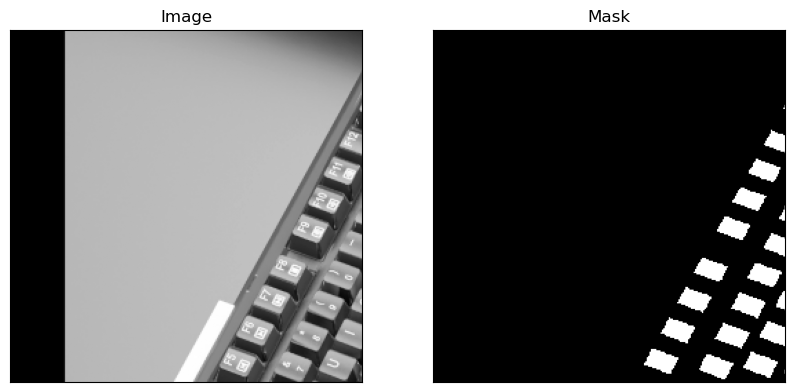

In [13]:
img_num = random.randint(0, len(dataset) - 1)
example_image = dataset[img_num]["image"]
example_mask = dataset[img_num]["label"]

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the first image on the left
axes[0].imshow(np.array(example_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(example_mask, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()

In [14]:
def get_bounding_box(ground_truth_map):
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

In [15]:
from torch.utils.data import Dataset

class SAMDataset(Dataset):
  """
  This class is used to create a dataset that serves input images and masks.
  It takes a dataset and a processor as input and overrides the __len__ and __getitem__ methods of the Dataset class.
  """
  def __init__(self, dataset, processor):
    self.dataset = dataset
    self.processor = processor

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    item = self.dataset[idx]
    image = item["image"]
    ground_truth_mask = np.array(item["label"])

    # get bounding box prompt
    prompt = get_bounding_box(ground_truth_mask)

    # prepare image and prompt for the model
    image = image.convert("RGB")
    inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")

    # remove batch dimension which the processor adds by default
    inputs = {k:v.squeeze(0) for k,v in inputs.items()}

    # add ground truth segmentation
    inputs["ground_truth_mask"] = ground_truth_mask

    return inputs

In [16]:
# Initialize the processor
from transformers import SamProcessor
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

In [17]:
# Create an instance of the SAMDataset
train_dataset = SAMDataset(dataset=dataset, processor=processor)

In [18]:
example = train_dataset[0]
for k,v in example.items():
  print(k,v.shape)

pixel_values torch.Size([3, 1024, 1024])
original_sizes torch.Size([2])
reshaped_input_sizes torch.Size([2])
input_boxes torch.Size([1, 4])
ground_truth_mask (256, 256)


/home/michalp/anaconda3/envs/knr/lib/python3.11/site-packages/transformers/image_processing_utils.py:41: UserWarning: The following named arguments are not valid for `SamImageProcessor.preprocess` and were ignored: 'point_pad_value'
  return self.preprocess(images, **kwargs)


In [19]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, drop_last=False)

In [20]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  print(k,v.shape)

pixel_values torch.Size([2, 3, 1024, 1024])
original_sizes torch.Size([2, 2])
reshaped_input_sizes torch.Size([2, 2])
input_boxes torch.Size([2, 1, 4])
ground_truth_mask torch.Size([2, 256, 256])


In [21]:
batch["ground_truth_mask"].shape    

torch.Size([2, 256, 256])

In [22]:
# Load the model
from transformers import SamModel
model = SamModel.from_pretrained("facebook/sam-vit-base")

# make sure we only compute gradients for mask decoder
for name, param in model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)

In [23]:
from torch.optim import Adam
import monai
# Initialize the optimizer and the loss function
optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)
#Try DiceFocalLoss, FocalLoss, DiceCELoss
seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

In [24]:
from tqdm import tqdm
from statistics import mean
import torch
from torch.nn.functional import threshold, normalize

#Training loop
num_epochs = 1

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()
for epoch in range(num_epochs):
    epoch_losses = []
    for batch in tqdm(train_dataloader):
      # forward pass
      outputs = model(pixel_values=batch["pixel_values"].to(device),
                      input_boxes=batch["input_boxes"].to(device),
                      multimask_output=False)

      # compute loss
      predicted_masks = outputs.pred_masks.squeeze(1)
      ground_truth_masks = batch["ground_truth_mask"].float().to(device)
      loss = seg_loss(predicted_masks, ground_truth_masks.unsqueeze(1))

      # backward pass (compute gradients of parameters w.r.t. loss)
      optimizer.zero_grad()
      loss.backward()

      # optimize
      optimizer.step()
      epoch_losses.append(loss.item())

    print(f'EPOCH: {epoch}')
    print(f'Mean loss: {mean(epoch_losses)}')

  0%|          | 0/831 [00:00<?, ?it/s]/home/michalp/anaconda3/envs/knr/lib/python3.11/site-packages/transformers/image_processing_utils.py:41: UserWarning: The following named arguments are not valid for `SamImageProcessor.preprocess` and were ignored: 'point_pad_value'
  return self.preprocess(images, **kwargs)
100%|██████████| 831/831 [04:15<00:00,  3.26it/s]

EPOCH: 0
Mean loss: 0.26813849700989134


In [25]:
# Save the model's state dictionary to a file
torch.save(model.state_dict(), "key_detection_model.pth")

In [26]:
from transformers import SamModel, SamConfig, SamProcessor
import torch

In [27]:
model_config = SamConfig.from_pretrained("facebook/sam-vit-base")
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

# Create an instance of the model architecture with the loaded configuration
keyboard_model = SamModel(config=model_config)
#Update the model by loading the weights from saved file.
keyboard_model.load_state_dict(torch.load("key_detection_model.pth"))

/tmp/ipykernel_24615/589471446.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  keyboard_model.load_state_dict(torch.load("key_detection_model.pth"))


<All keys matched successfully>

In [28]:
# set the device to cuda if available, otherwise use cpu
device = "cuda" if torch.cuda.is_available() else "cpu"
keyboard_model.to(device)

SamModel(
  (shared_image_embedding): SamPositionalEmbedding()
  (vision_encoder): SamVisionEncoder(
    (patch_embed): SamPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (layers): ModuleList(
      (0-11): 12 x SamVisionLayer(
        (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): SamVisionAttention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (layer_norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): SamMLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELUActivation()
        )
      )
    )
    (neck): SamVisionNeck(
      (conv1): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (layer_norm1): SamLayerNorm()
     

In [29]:
array_size = 256

# Define the size of your grid
grid_size = 10

# Generate the grid points
x = np.linspace(0, array_size-1, grid_size)
y = np.linspace(0, array_size-1, grid_size)

# Generate a grid of coordinates
xv, yv = np.meshgrid(x, y)

# Convert the numpy arrays to lists
xv_list = xv.tolist()
yv_list = yv.tolist()

# Combine the x and y coordinates into a list of list of lists
input_points = [[[int(x), int(y)] for x, y in zip(x_row, y_row)] for x_row, y_row in zip(xv_list, yv_list)]

#We need to reshape our nxn grid to the expected shape of the input_points tensor
# (batch_size, point_batch_size, num_points_per_image, 2),
# where the last dimension of 2 represents the x and y coordinates of each point.
#batch_size: The number of images you're processing at once.
#point_batch_size: The number of point sets you have for each image.
#num_points_per_image: The number of points in each set.
input_points = torch.tensor(input_points).view(1, 1, grid_size*grid_size, 2)
     

print(np.array(input_points).shape)

(1, 1, 100, 2)


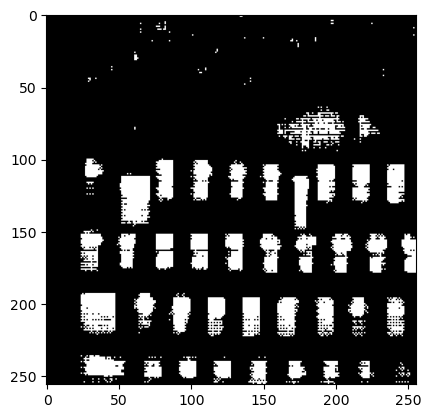

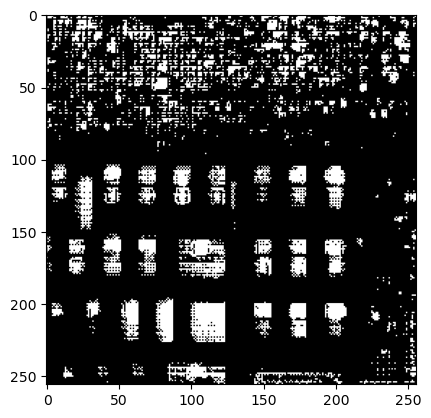

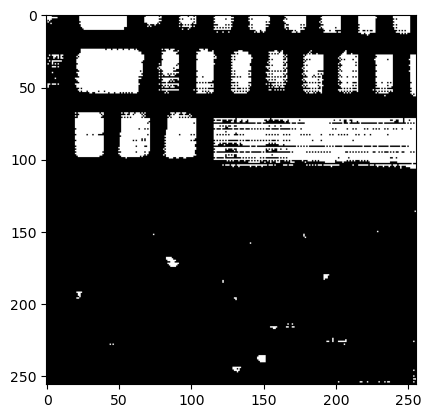

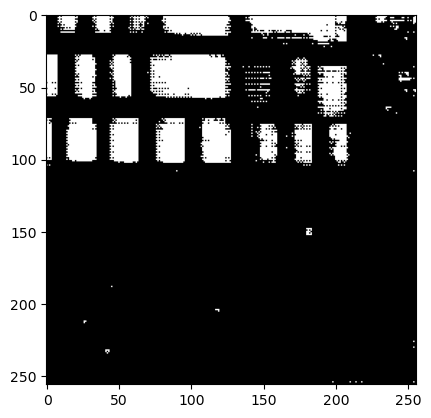

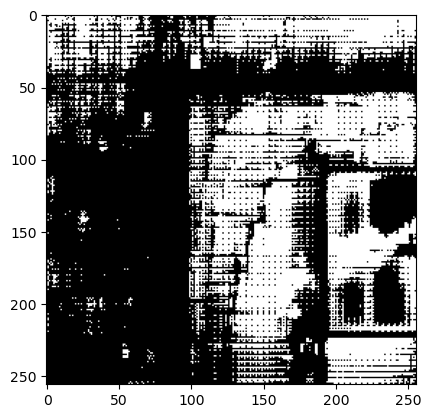

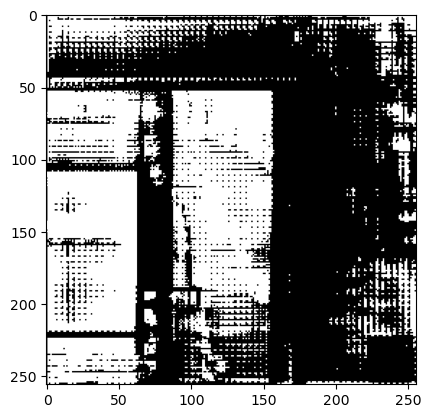

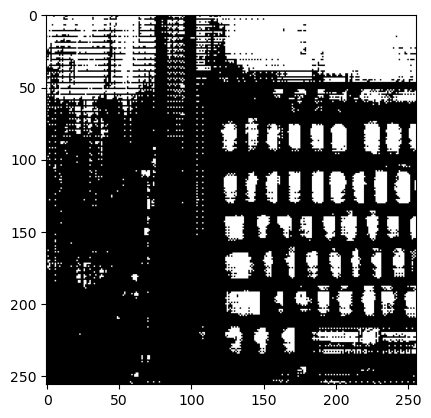

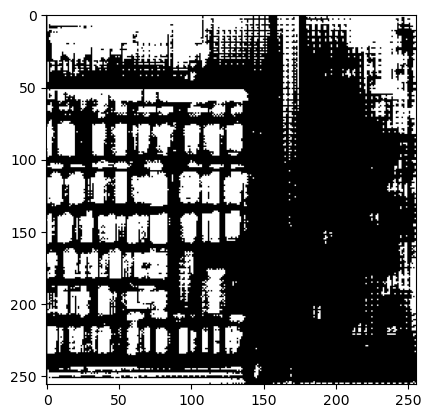

: 

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt

dir = "./real_testing"
paths = [path for path in os.listdir(dir) if "Image" in path]

images = [cv2.imread(os.path.join(dir, path), cv2.IMREAD_GRAYSCALE) for path in paths]
images_square = [np.array(make_square(image)) for image in images]
images_resized = np.array([cv2.resize(image, (512, 512)) for image in images])

all_img_patches = []
for img in range(images_resized.shape[0]):
    large_image = images_resized[img]
    patches_img = patchify(large_image, (patch_size, patch_size), step=step)  #Step=256 for 256 patches means no overlap

    for i in range(patches_img.shape[0]):
        for j in range(patches_img.shape[1]):

            single_patch_img = patches_img[i,j,:,:]
            all_img_patches.append(single_patch_img)

images_resized = np.array(all_img_patches)

keyboard_model.eval()
masks_patches = []

for i in range(images_resized.shape[0]):
    image = images_resized[i]
    image = Image.fromarray(image)
    image = image.convert("RGB")
    inputs = processor(image, return_tensors="pt", input_points=input_points)
    inputs = {k:v.to(device) for k,v in inputs.items()}
    with torch.no_grad():
        outputs = keyboard_model(**inputs, multimask_output=False)
    # apply sigmoid
    single_patch_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
    # convert soft mask to hard mask
    single_patch_prob = single_patch_prob.cpu().numpy().squeeze()
    single_patch_prediction = (single_patch_prob > 0.6).astype(np.uint8)
    plt.imshow(single_patch_prediction, cmap='gray')
    plt.show()